# Sentiment Analysis

## Imports, setup and constants

In [1]:
from __future__ import annotations

import warnings
from collections import Counter
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from wordcloud import WordCloud

In [2]:
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
DATASET_PATH = DATA_DIR / "sentiment140.csv"

SEED = 42
CACHE = joblib.Memory(".cache", verbose=0)

In [3]:
nlp = spacy.load("en_core_web_sm")

## Data

### Data loading

In [4]:
# Load the dataset
data = pd.read_csv(
    DATASET_PATH,
    encoding="ISO-8859-1",
    names=[
        "target",  # 0 = negative, 2 = neutral, 4 = positive
        "id",  # The id of the tweet
        "date",  # The date of the tweet
        "flag",  # The query, NO_QUERY if not present
        "user",  # The user that tweeted
        "text",  # The text of the tweet
    ],
)

# Ignore rows with neutral sentiment
data = data[data["target"] != 2]

# Map sentiment values
data["sentiment"] = data["target"].map(
    {
        0: 0,  # Negative
        4: 1,  # Positive
    },
)

# Show the first rows
data.head()

,target,id,date,flag,user,text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


In [5]:
# Convert to lists
X = data["text"].tolist()
y = data["sentiment"].tolist()

# Only use a small subset of the data with equal class distribution
X, _, y, _ = train_test_split(X, y, test_size=0.99, stratify=y, shuffle=True, random_state=SEED)

# Compare sizes
print(f"Original size: {len(data)}")
print(f"Reduced size: {len(y)}")

Original size: 1600000
Reduced size: 16000


### Data exploration

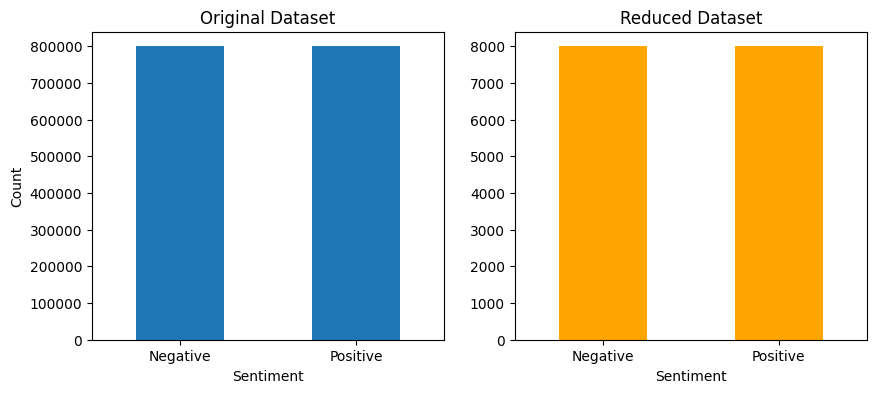

In [6]:
# Plot the distribution of the entire dataset and the reduced one
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

data["sentiment"].value_counts().plot(kind="bar", ax=ax1)
ax1.set_title("Original Dataset")
ax1.set_xticklabels(["Negative", "Positive"], rotation=0)
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Count")

pd.Series(y).value_counts().plot(kind="bar", ax=ax2, color="orange")
ax2.set_title("Reduced Dataset")
ax2.set_xticklabels(["Negative", "Positive"], rotation=0)
ax2.set_xlabel("Sentiment")

plt.show()

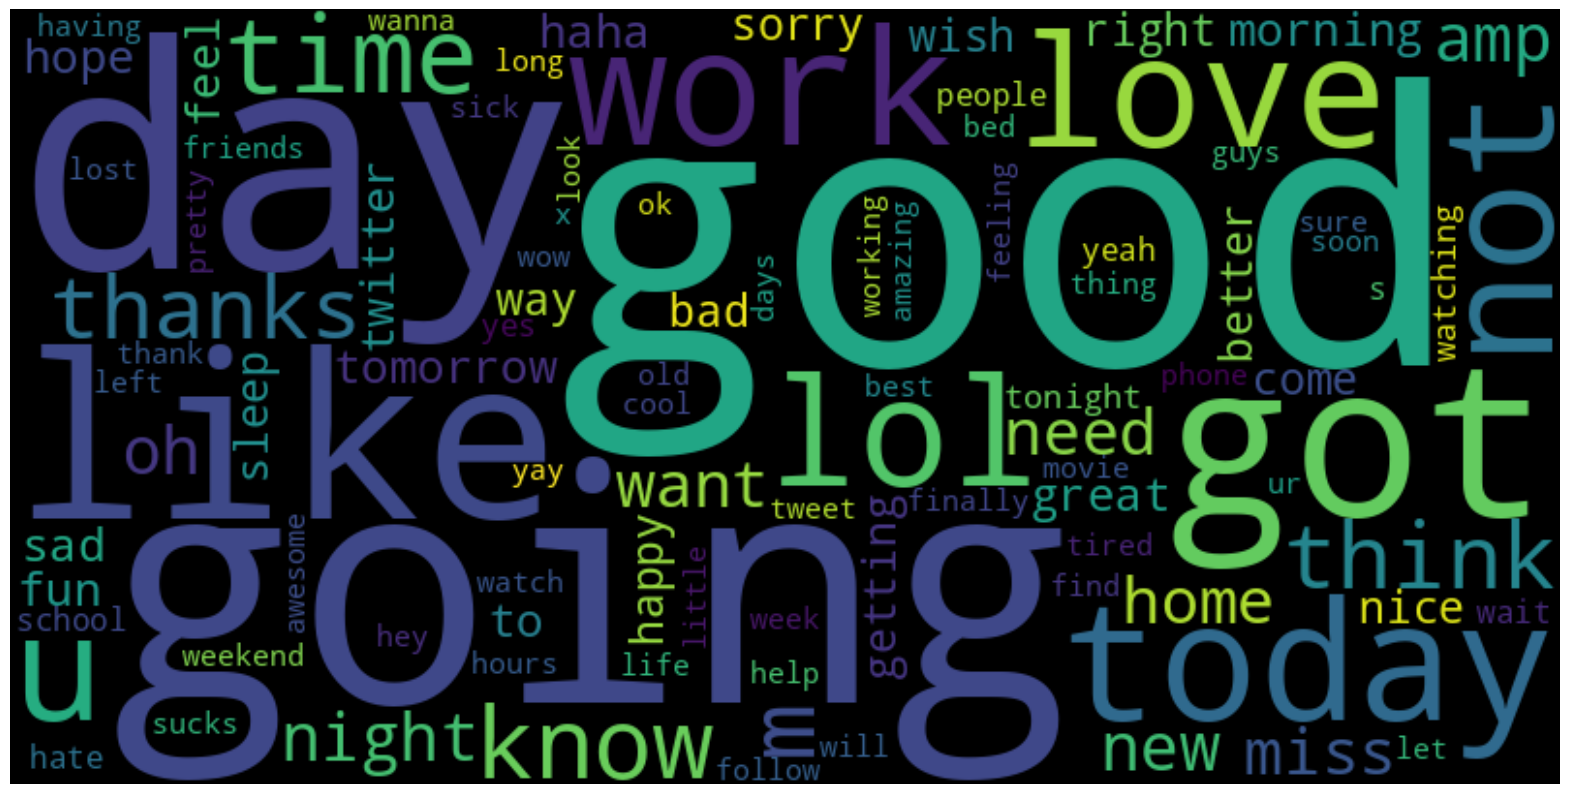

In [7]:
@CACHE.cache
def get_words(texts: list[str]) -> list[str]:
    words = []
    for doc in tqdm(nlp.pipe(texts, disable=["parser", "ner"], batch_size=1024), total=len(X)):
        words.extend([token.norm_ for token in doc if token.text.isalpha() and not token.is_stop])
    return words


# Get all the words in the dataset
words = get_words(X)

# Now take the most common words
word_freq = Counter(words)
common_words = word_freq.most_common(100)

# Create a word cloud of the most common words
cloud = WordCloud(width=800, height=400, random_state=SEED).generate_from_frequencies(dict(common_words))

# Display the word cloud
plt.figure(figsize=(20, 20))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data preprocessing

In [8]:
class TextTokenizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        *,
        character_threshold: int = 2,
        batch_size: int = 512,
        n_jobs: int = 8,
    ) -> None:
        self.character_threshold = character_threshold
        self.batch_size = batch_size
        self.n_jobs = n_jobs

    def fit(self, _data: list[str], _labels: list[int] | None = None) -> TextTokenizer:
        return self

    def transform(self, data: list[str]) -> list[list[str]]:
        tokenized = []
        for doc in tqdm(nlp.pipe(data, batch_size=self.batch_size, n_process=self.n_jobs), total=len(data)):
            tokens = []
            for token in doc:
                # Ignore stop words and punctuation
                if token.is_stop or token.is_punct:
                    continue
                # Ignore emails, URLs and numbers
                if token.like_email or token.like_email or token.like_num:
                    continue

                # Lemmatize and lowercase
                tok = token.lemma_.lower().strip()

                # Format hashtags
                if tok.startswith("#"):
                    tok = tok[1:]

                # Ignore short and non-alphanumeric tokens
                if len(tok) < self.character_threshold or not tok.isalnum():
                    continue

                # TODO: Emoticons and emojis
                # TODO: Spelling correction

                tokens.append(tok)
            tokenized.append(tokens)
        return tokenized

In [ ]:
def identity(x: list[str]) -> list[str]:
    return x

In [10]:
# Preprocess the data
data_pipeline = Pipeline(
    [
        ("tokenizer", TextTokenizer()),
        (
            "vectorizer",
            TfidfVectorizer(
                max_features=20000,
                ngram_range=(1, 2),
                # disable text processing
                tokenizer=identity,
                preprocessor=identity,
                lowercase=False,
                token_pattern=None,
            ),
        ),
    ],
    memory=CACHE,
)

In [11]:
# Fit the pipeline
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Prevent joblib warnings
    data_pipeline.fit(X)

# Transform the data
X = data_pipeline.transform(X)

100%|██████████| 16000/16000 [00:17<00:00, 925.91it/s] 


In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)

## Model

In [13]:
# Define the classifiers
clfs = [
    (
        LogisticRegression(max_iter=1000, random_state=SEED),
        {
            "C": np.logspace(-3, 3, 20),
            "solver": ["saga", "liblinear"],
            "penalty": ["l1", "l2"],
        },
    ),
    (LinearSVC(max_iter=10000, dual=False, random_state=SEED), {"C": np.logspace(-3, 3, 20)}),
    (KNeighborsClassifier(), {"n_neighbors": np.arange(1, 10)}),
    (DecisionTreeClassifier(random_state=SEED), {"max_depth": np.arange(1, 10)}),
    (ExtraTreesClassifier(random_state=SEED), {"n_estimators": np.arange(100, 500, 100)}),
]

In [14]:
results = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F1", "ROC AUC"])
models = []

In [19]:
# Perform random search
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for i, (clf, params) in enumerate(tqdm(clfs)):
    name = clf.__class__.__name__

    # Find the best hyperparameters
    search = RandomizedSearchCV(
        clf,
        params,
        cv=kfold,
        n_iter=10,
        scoring="accuracy",
        random_state=SEED,
        verbose=1,
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # To prevent joblib warning spam
        search.fit(X_train, y_train)

    # Evaluate the model
    y_pred = search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Save the results
    results.loc[i] = [name, accuracy, precision, recall, f1, roc_auc]
    models.append(search.best_estimator_)

  0%|          | 0/10 [00:00<?, ?it/s]

Fitting 3 folds for each of 7 candidates, totalling 21 fits


 10%|█         | 1/10 [01:00<09:03, 60.38s/it]

Fitting 3 folds for each of 7 candidates, totalling 21 fits


 20%|██        | 2/10 [01:35<06:04, 45.61s/it]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


 30%|███       | 3/10 [05:29<15:21, 131.71s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 40%|████      | 4/10 [05:44<08:32, 85.49s/it] 

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|█████     | 5/10 [05:47<04:38, 55.60s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 60%|██████    | 6/10 [10:25<08:45, 131.48s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 70%|███████   | 7/10 [33:51<27:24, 548.16s/it]

Fitting 3 folds for each of 4 candidates, totalling 12 fits


 80%|████████  | 8/10 [53:21<24:52, 746.17s/it]

Fitting 3 folds for each of 9 candidates, totalling 27 fits


 90%|█████████ | 9/10 [1:00:10<10:40, 640.70s/it]

Fitting 3 folds for each of 4 candidates, totalling 12 fits


100%|██████████| 10/10 [1:04:08<00:00, 384.84s/it]


,Classifier,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression,0.747188,0.749250,0.761585,0.755367,0.746818
1,LinearSVC,0.746875,0.748206,0.762805,0.755435,0.746467
2,ExtraTreesClassifier,0.734688,0.727691,0.770732,0.748593,0.733763
3,GradientBoostingClassifier,0.727187,0.699221,0.820732,0.755119,0.724789
4,RandomForestClassifier,0.723437,0.718587,0.756707,0.737155,0.722584


In [20]:
# Save and show the results
sorted_results = results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
sorted_results.to_csv(DATA_DIR / "proto_results2.csv", index=False)
sorted_results.head()

,Classifier,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression,0.747188,0.749250,0.761585,0.755367,0.746818
1,LinearSVC,0.746875,0.748206,0.762805,0.755435,0.746467
2,ExtraTreesClassifier,0.734688,0.727691,0.770732,0.748593,0.733763
3,GradientBoostingClassifier,0.727187,0.699221,0.820732,0.755119,0.724789
4,RandomForestClassifier,0.723437,0.718587,0.756707,0.737155,0.722584


## Evaluation

In [ ]:
def evaluate_model(clf: BaseEstimator) -> None:
    # Calculate the accuracy
    accuracy = clf.score(X_test, y_test)

    # Calculate the confusion matrix
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    categories = ["Negative", "Positive"]
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_percentages = [f"{value:.2%}" for value in cm.flatten() / cm.sum()]

    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    _, ax = plt.subplots(figsize=(8, 6))
    ax.grid(False)
    ax.set_title(f"Accuracy: {accuracy:.2%}")
    sns.heatmap(
        cm,
        xticklabels=categories,
        yticklabels=categories,
        annot=labels,
        square=True,
        cbar=False,
        cmap="viridis",
        linewidths=0.5,
        fmt="",
        ax=ax,
    )
    plt.show()

In [ ]:
# Evaluate the best model
best_model = models[results["Accuracy"].idxmax()]
evaluate_model(best_model)